In [1]:
import sys
import os

#sys.path.insert(0, os.path.abspath("."))
#sys.path.append(os.path.abspath("../../../"))

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
from desc.backend import put, fori_loop, jnp, sign
from desc.utils import cross, dot
from desc.transform import Transform

from desc.derivatives import Derivative
from desc.basis import DoubleFourierSeries
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.grid import Grid, LinearGrid

from desc.magnetic_fields import FourierCurrentPotentialField

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           plot_figure4,
                           #plot_xy,
                           surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-40GB (id=0), with 40.00 GB available memory

In [4]:
# Define function to find A and its respective derivatives
def eqn_residual(data, # Data on the winding surface
                 b_mn,
                 basis_b,
                 transform1,
                ):
    
    #b_mn = b_n[0:basis_b.num_modes]
    
    fs = {"b_t": transform1.transform(b_mn, dt = 1),
          "b_z": transform1.transform(b_mn, dz = 1),
          "b_tt": transform1.transform(b_mn, dt = 2),
          "b_tz": transform1.transform(b_mn, dt = 1, dz = 1),
          "b_zz": transform1.transform(b_mn, dz = 2),
         }

    lp = (jnp.sum(data["e^theta_s"] * data["e^theta_s_t"], axis=-1) * fs["b_t"]
          + jnp.sum(data["e^theta_s"] * data["e^theta_s"], axis=-1) * fs["b_tt"]
          + jnp.sum(data["e^theta_s"] * data["e^zeta_s_t"], axis=-1) * fs["b_z"]
          + jnp.sum(data["e^theta_s"] * data["e^zeta_s"], axis=-1) * fs["b_tz"]
          + jnp.sum(data["e^zeta_s"] * data["e^theta_s_z"], axis=-1) * fs["b_t"]
          + jnp.sum(data["e^theta_s"] * data["e^zeta_s"], axis=-1) * fs["b_tz"]
          + jnp.sum(data["e^zeta_s"] * data["e^zeta_s_z"], axis=-1) * fs["b_z"]
          + jnp.sum(data["e^zeta_s"] * data["e^zeta_s"], axis=-1) * fs["b_zz"]
          )
    
    return lp

In [5]:
#eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
#eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium

from desc.io import InputReader, load
from desc.examples import get
#eq = get('precise_QA')
surf = load("/home/fcastro/LMStell/sigma/RQA/surf5/surf_opt_2.h5")
#eq2 = load(eqname_QA)[4]
#eqfam2 = EquilibriaFamily(eq2)

In [6]:
basis_M = 30
basis_N = 30

surface_current_field = FourierCurrentPotentialField.from_surface(surf,
                                                                  M_Phi=basis_M,
                                                                  N_Phi=basis_N,
                                                                  #sym_Phi = True
                                                                 )

tgrid = LinearGrid(M=60,N=60,
                   NFP=surf.NFP
                  )
tdata = surface_current_field.compute(["theta","zeta","|e_theta x e_zeta|",
                                       "nabla_s^2_theta","nabla_s^2_zeta",
                                       "e^theta_s","e^zeta_s",
                                       "e^theta_s_t","e^theta_s_z",
                                       "e^zeta_s_t","e^zeta_s_z",
                                       #"H_1","H_2",
                                       #"lambda_iso"
                                      ],grid = tgrid)
#surf_int(tdata["G"],tdata,tgrid)

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

In [7]:
b_basis = DoubleFourierSeries(M = basis_M, N = basis_N, 
                                   NFP = surf.NFP, 
                                   sym = "sin"
                                  )

x = jnp.ones(b_basis.num_modes)

ktrans = Transform(tgrid, b_basis, 
                   derivs = 2, build=True,)

fun_wrapped = lambda x: eqn_residual(tdata, # Data on the winding surface
                                       x,
                                       b_basis,
                                       ktrans,
                                       )

<class 'numpy.ndarray'>

In [8]:
#A = jax.jacfwd(fun_wrappedC)(bg)
A = Derivative(fun_wrapped, deriv_mode="looped").compute(x)

In [9]:
rhs = tdata["nabla_s^2_zeta"]
b_soln = jnp.linalg.pinv(A)@rhs

# Find the error
residual = np.abs(A@b_soln - rhs)
max(residual)

np.save("zeta_sol.npy",b_soln)

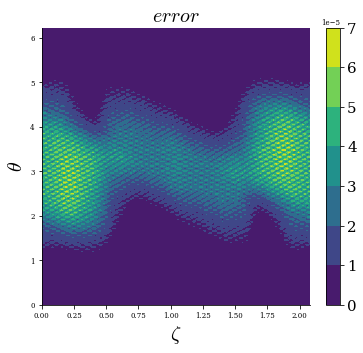

In [10]:
plot_figure2(residual,
             tgrid,
             ''r'$ error $ ')

In [11]:
surface_current_field.Phi_mn = b_soln

In [12]:
sdata = surface_current_field.compute(["Phi","grad_s(Phi)",
                                       "e^theta_s","e^zeta_s",
                                       "theta","zeta",
                                       #"u_iso","v_iso","H_1","H_2",
                                      ],grid = tgrid)

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

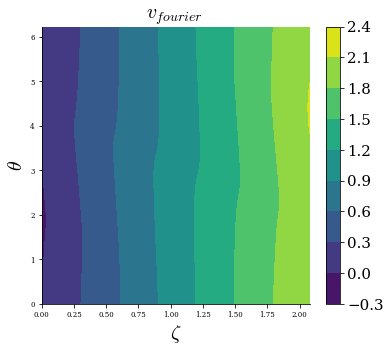

In [13]:
plot_figure2(sdata["zeta"] - sdata["Phi"],
             tgrid,
             ''r'$ u_{fourier} $ ')

In [14]:
test = sdata["e^zeta_s"] - sdata["grad_s(Phi)"]

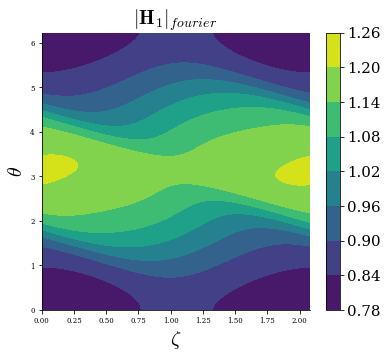

In [15]:
plot_figure2(dot(test,test)**(1/2),
             tgrid,
             ''r'$ |\mathbf{H}_1|_{fourier} $ ')

In [16]:
rhs = tdata["nabla_s^2_theta"]
b_soln = jnp.linalg.pinv(A)@rhs

# Find the error
residual = np.abs(A@b_soln - rhs)
max(residual)

np.save("theta_sol.npy",b_soln)

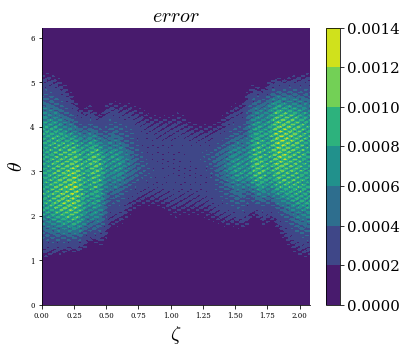

In [17]:
plot_figure2(residual,
             tgrid,
             ''r'$ error $ ')

In [18]:
surface_current_field.Phi_mn = b_soln
sdata = surface_current_field.compute(["Phi","grad_s(Phi)",
                                       #"Phi_t","Phi_z",
                                       "e^theta_s","e^zeta_s",
                                       "theta","zeta",
                                       #"u_iso","v_iso","H_1","H_2",
                                      ],grid = tgrid)

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

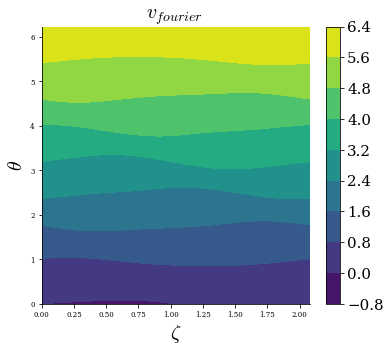

In [19]:
plot_figure2(sdata["theta"] - sdata["Phi"],
             tgrid,
             ''r'$ v_{fourier} $ ')

In [20]:
test = sdata["e^theta_s"] - sdata["grad_s(Phi)"]

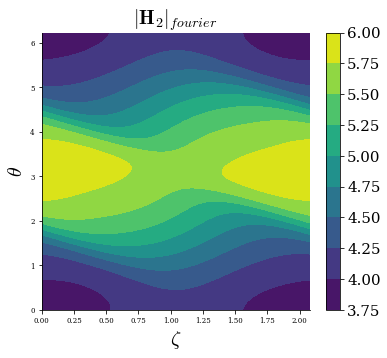

In [21]:
plot_figure2(dot(test,test)**(1/2),
             tgrid,
             ''r'$ |\mathbf{H}_2|_{fourier} $ ')